## 🧠 LangGraph 기반 교육 요청 처리기:

### 🌟 단계 1: 사용자의 요청을 입력합니다.
예: "입문자를 위한 파이썬 커리큘럼 추천해줘"

### 🌟 단계 2: 어떤 유형인지 자동 분류합니다.
요청이 "수업인가?", "책 추천인가?", "일반 대화인가?" 판단합니다.

### 🌟 단계 3: 분류 결과에 따라 다른 처리 경로(노드)로 보냅니다.
- 수업이면 ➝ 커리큘럼 설계 노드
- 책 추천이면 ➝ 독서 추천 노드
- 설명 요청이면 ➝ 일반 대화 노드
- 그 외엔 ➝ 간단한 조언 노드

### 🌟 단계 4: 결과를 구조화된 형식으로 반환합니다.
→ 커리큘럼/책/답변/조언이 깔끔하게 출력됩니다!

**즉, 이 시스템은 "사용자 요청을 자동 분류하고, 알맞은 처리기로 보내는 똑똑한 라우터"입니다.**

In [2]:
from langchain_openai import ChatOpenAI

# LLM 인스턴스 생성
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0
)

print("✅ LLM 초기화 완료!")

/Users/jinhohyeon/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


✅ LLM 초기화 완료!


# 📌 예제 1: 교육 요청 라우터 (Router Pattern)

## 핵심 개념
- 사용자 요청을 자동으로 분류
- 분류 결과에 따라 다른 노드로 라우팅
- 각 노드는 전문화된 작업 수행

In [3]:
from typing import TypedDict, List, Literal
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate

# 커리큘럼 구조 정의
class Syllabus(BaseModel):
    course_title: str = Field(description="과목 이름")
    level: str = Field(description="난이도")
    modules: List[str] = Field(description="주요 모듈")

# 독서 추천 구조 정의
class ReadingPick(BaseModel):
    book_title: str = Field(description="도서 제목")
    author: str = Field(description="저자")
    why_read: str = Field(description="추천 이유")

# 상태 정의
class ServiceState(TypedDict):
    request_text: str       # 사용자 입력
    intent_label: str       # 의도 라벨 (COURSE/BOOK/CHAT)
    syllabus: Syllabus      # 커리큘럼 결과
    reading: ReadingPick    # 독서 추천 결과
    general_note: str       # 일반 대화 결과

print("✅ 데이터 구조 정의 완료!")

✅ 데이터 구조 정의 완료!


In [4]:
# 1. 의도 분류 노드
def detect_intent(state: ServiceState):
    """사용자 요청을 COURSE/BOOK/CHAT 중 하나로 분류"""
    prompt = ChatPromptTemplate([
        ('system', '''사용자 요청을 다음 중 하나로 분류하세요:
1) 교육 과정/커리큘럼: 'COURSE'
2) 독서 추천: 'BOOK'
3) 일반 대화/설명: 'CHAT'
라벨 하나만 출력하세요.'''),
        ('user', '{request_text}')
    ])
    result = (prompt | llm).invoke(state)
    return {"intent_label": result.content}

# 2. 커리큘럼 설계 노드
def design_curriculum(state: ServiceState):
    """커리큘럼을 구조화하여 생성"""
    prompt = ChatPromptTemplate([
        ('system', '교육과정 설계 전문가로서 커리큘럼을 작성하세요.'),
        ('user', '{request_text}')
    ])
    chain = prompt | llm.with_structured_output(Syllabus)
    return {'syllabus': chain.invoke(state)}

# 3. 독서 추천 노드
def suggest_reading(state: ServiceState):
    """도서를 추천"""
    prompt = ChatPromptTemplate([
        ('system', '독서 추천 전문가로서 책을 추천하세요.'),
        ('user', '{request_text}')
    ])
    chain = prompt | llm.with_structured_output(ReadingPick)
    return {'reading': chain.invoke(state)}

# 4. 일반 대화 노드
def tutor_chat(state: ServiceState):
    """일반 질문에 답변"""
    result = llm.invoke(state['request_text'])
    return {'general_note': result.content}

# 5. 분기 결정 함수
def select_handler(state: ServiceState):
    """의도에 따라 다음 노드 선택"""
    if "COURSE" in state["intent_label"]:
        return "design_curriculum"
    elif "BOOK" in state["intent_label"]:
        return "suggest_reading"
    else:
        return "tutor_chat"

print("✅ 노드 함수 정의 완료!")

✅ 노드 함수 정의 완료!


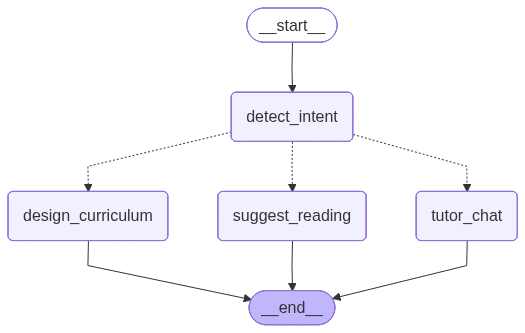

In [5]:
# 그래프 구성
from langgraph.graph import StateGraph, START, END

builder = StateGraph(ServiceState)

# 노드 추가
builder.add_node('detect_intent', detect_intent)
builder.add_node('design_curriculum', design_curriculum)
builder.add_node('suggest_reading', suggest_reading)
builder.add_node('tutor_chat', tutor_chat)

# 엣지 연결
builder.add_edge(START, 'detect_intent')
builder.add_conditional_edges(
    'detect_intent',
    select_handler,
    {
        'design_curriculum': 'design_curriculum',
        'suggest_reading': 'suggest_reading',
        'tutor_chat': 'tutor_chat'
    }
)
builder.add_edge('design_curriculum', END)
builder.add_edge('suggest_reading', END)
builder.add_edge('tutor_chat', END)

# 컴파일
graph = builder.compile()
graph

In [6]:
# 예제 실행 1: 커리큘럼 요청
result = graph.invoke({'request_text': '파이썬 입문 커리큘럼 추천해줘'})
print("\n📚 커리큘럼 결과:")
print(result['syllabus'])


📚 커리큘럼 결과:
course_title='파이썬 입문' level='초급' modules=['파이썬 소개 및 설치', '기본 문법 및 데이터 타입', '조건문과 반복문', '함수와 모듈', '리스트, 튜플, 딕셔너리', '파일 입출력', '예외 처리', '기본적인 객체지향 프로그래밍', '파이썬 라이브러리 소개 (NumPy, Pandas 등)', '간단한 프로젝트 실습']


In [7]:
# 예제 실행 2: 도서 추천
result = graph.invoke({'request_text': '자료구조 입문서 추천해줘'})
print("\n📖 도서 추천 결과:")
print(result['reading'])


📖 도서 추천 결과:
book_title='자료구조와 알고리즘 분석' author='마이클 T. 개스퍼' why_read='이 책은 자료구조와 알고리즘의 기초를 체계적으로 설명하고 있어, 초보자들이 이해하기 쉽게 구성되어 있습니다. 다양한 예제와 연습문제를 통해 실력을 쌓을 수 있으며, 이론과 실제를 연결하는 데 도움을 줍니다.'


In [8]:
# 예제 실행 3: 일반 질문
result = graph.invoke({'request_text': 'KNN 알고리즘을 간단히 설명해줘'})
print("\n💬 일반 답변 결과:")
print(result['general_note'])


💬 일반 답변 결과:
KNN(최근접 이웃 알고리즘, K-Nearest Neighbors)은 분류 및 회귀 문제에 사용되는 간단하고 직관적인 머신러닝 알고리즘입니다. KNN의 기본 아이디어는 주어진 데이터 포인트의 클래스를 결정할 때, 그와 가장 가까운 K개의 이웃 데이터 포인트를 참조하는 것입니다.

### KNN의 작동 방식:

1. **데이터 준비**: 훈련 데이터셋을 준비합니다. 각 데이터 포인트는 여러 특성(피처)과 레이블(클래스)을 가집니다.

2. **거리 측정**: 새로운 데이터 포인트가 주어지면, 훈련 데이터셋의 모든 포인트와의 거리를 계산합니다. 일반적으로 유클리드 거리(Euclidean distance)를 많이 사용하지만, 맨해튼 거리(Manhattan distance) 등 다른 거리 측정 방법도 사용할 수 있습니다.

3. **K개의 이웃 선택**: 계산된 거리 중에서 가장 가까운 K개의 이웃을 선택합니다.

4. **투표 또는 평균**:
   - **분류 문제**: K개의 이웃 중에서 가장 많이 나타나는 클래스를 선택하여 새로운 데이터 포인트의 클래스를 결정합니다.
   - **회귀 문제**: K개의 이웃의 값을 평균내어 새로운 데이터 포인트의 값을 예측합니다.

### KNN의 장점:
- 구현이 간단하고 이해하기 쉬움.
- 훈련 과정이 필요 없고, 새로운 데이터에 대해 즉시 예측 가능.

### KNN의 단점:
- 데이터가 많아질수록 계산 비용이 증가하여 느려질 수 있음.
- K 값의 선택이 결과에 큰 영향을 미침.
- 고차원 데이터에서 성능이 저하될 수 있음(차원의 저주).

KNN은 간단하면서도 효과적인 알고리즘으로, 특히 데이터가 적고 명확한 경계가 있는 경우에 잘 작동합니다.
